In [17]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import csv as csv

# /Users/hayatoyamaguchi/Public/kaggle/House Price/house-prices-advanced-regression-techniques

path = "house-prices-advanced-regression-techniques/"
train_df = pd.read_csv(path+"train.csv", header=0)
test_df = pd.read_csv(path+"test.csv", header=0)
train_df['WhatIsData'] = 'Train'
test_df['WhatIsData'] = 'Test'
train_df.tail()

drop_train_df = train_df.drop('SalePrice',axis=1)
allData = pd.concat([drop_train_df,test_df],axis=0)
allData['TotalSF'] = allData['TotalBsmtSF'] + allData['1stFlrSF'] + allData['2ndFlrSF']
print(train_df.shape)
print(drop_train_df.shape)
print(test_df.shape)
print(allData.shape)
allData["LotFrontage"] = allData.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
na_col_list = allData.isnull().sum()[allData.isnull().sum()>0].sort_values(ascending=False).index.tolist()
for row in na_col_list:
    if allData[row].dtypes == "float64":
        allData[row][allData[row].isnull()] = 0
    else:
        allData[row][allData[row].isnull()] = "NA"

dropData = allData[allData.columns[allData.columns != "WhatIsData"]]

data_dummies = pd.get_dummies(dropData)
transdropData = pd.concat([dropData,data_dummies],axis=1)

transdropData = transdropData.select_dtypes(include=["float64","int64","uint8"])
transdropData = transdropData.astype('int')
a = transdropData.select_dtypes(include="object")
print(a.shape)
print(transdropData.shape)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
columns = transdropData.columns.values
transdropData_scaled = pd.DataFrame(scaler.fit(transdropData).transform(transdropData),columns=columns)
print(transdropData_scaled.shape)
print(allData["WhatIsData"].shape)
# transAllData = pd.concat([transdropData_scaled,allData["WhatIsData"]],axis=1)

transdropData_scaled["WhatIsData"] = list(allData["WhatIsData"])
transAllData = transdropData_scaled

from sklearn import preprocessing
lab_enc = preprocessing.LabelEncoder()
encoded = lab_enc.fit_transform(train_df["SalePrice"])
type(np.log(train_df["SalePrice"][0]))

transAllData2 = transAllData.loc[:,~transAllData.columns.duplicated()]
print(transAllData.shape)
print(transAllData2.shape)

X_train = transAllData2[transAllData2['WhatIsData']=='Train'].drop(['WhatIsData','Id'], axis=1)
y_train = np.log(train_df["SalePrice"])
X_test = transAllData2[transAllData2['WhatIsData']=='Test'].drop(['WhatIsData','Id'], axis=1)



(1460, 82)
(1460, 81)
(1459, 81)
(2919, 82)


/Users/hayatoyamaguchi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/hayatoyamaguchi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(2919, 0)
(2919, 351)
(2919, 351)
(2919,)
(2919, 352)
(2919, 314)


/Users/hayatoyamaguchi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/hayatoyamaguchi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=80, max_features='auto')
rf.fit(X_train, y_train)
ranking = np.argsort(-rf.feature_importances_)
X_train = X_train.iloc[:,ranking[:37]]
X_test = X_test.iloc[:,ranking[:37]]
X_train["Interaction"] = X_train["TotalSF"]*X_train["OverallQual"]
X_test["Interaction"] = X_test["TotalSF"]*X_test["OverallQual"]

In [19]:
from sklearn.linear_model import LinearRegression,Ridge
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.linear_model import Ridge


xgbr = xgb.XGBRegressor(max_depth=3,learning_rate=0.1,colsample_bytree=0.6)
xgbr.fit(X_train,y_train)

svr = SVR(C=3,gamma=0.001)
svr.fit(X_train,y_train)

lr = LinearRegression()
lr.fit(X_train,y_train)

ridge = Ridge(alpha=30)
ridge.fit(X_train,y_train)

X_train2 = pd.DataFrame({"XGB":xgbr.predict(X_train),"SVR":svr.predict(X_train)})
# X_train2 = pd.DataFrame({"XGB":xgbr.predict(X_train),"SVR":svr.predict(X_train)
#                          ,"Linear":lr.predict(X_train),"Ridge":ridge.predict(X_train)})
X_train2.head()

##スタッキングしたモデルの過学習を抑えるためには、訓練データをさらに分割して、分割した中の訓練データで学習して、交差検証データのスコアを出力すればいい

/Users/hayatoyamaguchi/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


,XGB,SVR
0,12.243317,12.214020
1,12.068380,12.142772
2,12.273511,12.290374
3,11.981495,12.025587
4,12.554801,12.577624


0.9490044528763043
0.9377482304975929


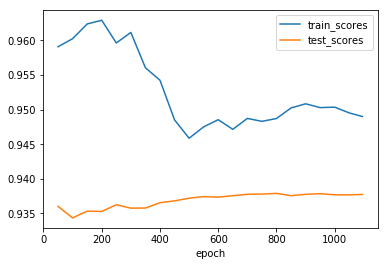

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
X_train2_train,X_val,y_train2_train,y_val = train_test_split(X_train2,y_train,random_state=0)
# epochs = [100,200,300,400,500,600,700,800,900,1000,1095]
epochs = [50,100,150,200,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000,1050,1095]
train_scores = []
test_scores = []
for epoch in epochs:
    model = LinearRegression()
    X_train_epoch = X_train2_train[:epoch]
    y_train_epoch = y_train2_train[:epoch]
#     print(X_train_epoch.shape)
#     print(y_train_epoch.shape)
    model.fit(X_train_epoch,y_train_epoch)
#     print(forest.score(X_train_epoch,y_train_epoch))
#     print(forest.score(X_val,y_val))
    train_scores.append(model.score(X_train_epoch,y_train_epoch))
    test_scores.append(model.score(X_val,y_val))
#     train_scores.append(np.sqrt(mean_squared_error(y_train_train ,model.predict(X_train_train))))
#     test_scores.append(np.sqrt(mean_squared_error(y_val,model.predict(X_val))))

    if epoch==1095:
#             print(np.sqrt(mean_squared_error(y_train_train ,model.predict(X_train_train))))
#             print(np.sqrt(mean_squared_error(y_val,model.predict(X_val))))
            print(model.score(X_train_epoch,y_train_epoch))
            print(model.score(X_val,y_val))
    
import matplotlib.pyplot as plt
%matplotlib inline
x = epochs
y0 = train_scores
y1 = test_scores
fig = plt.figure()
plt.xlabel('epoch')
plt.plot(x, y0, label='train_scores')
plt.plot(x, y1, label='test_scores')
plt.legend()
plt.show()

In [21]:
from sklearn import linear_model
from datetime import datetime
from sklearn.model_selection import train_test_split
X_train2_train,X_val2,y_train2_train,y_val2 = train_test_split(X_train2,y_train,random_state=0)

time= datetime.now().strftime("%Y%m%d-%H%M%S")

reg = linear_model.LinearRegression()
reg.fit(X_train2_train,y_train2_train)

print(y_train2_train.shape)
print(X_train2_train.shape)
print(np.sqrt(mean_squared_error(y_train2_train ,reg.predict(X_train2_train))))
print(np.sqrt(mean_squared_error(y_val2,reg.predict(X_val2))))

print(reg.coef_)

# X_test2 = pd.DataFrame({"XGB":xgbr.predict(X_test),"SVR":svr.predict(X_test)
#                          ,"Linear":lr.predict(X_test),"Ridge":ridge.predict(X_test)})
X_test2 = pd.DataFrame({"XGB":xgbr.predict(X_test),"SVR":svr.predict(X_test)})

predictions = np.exp(reg.predict(X_test2))

df_result = pd.DataFrame()
df_result['Id'] = test_df['Id']
df_result['SalePrice'] = predictions
df_result.to_csv('result.csv'+time,index=False)
df_result.head()

(1095,)
(1095, 2)
0.09189946389474833
0.09777482800104982
[ 1.13769651 -0.11120012]


,Id,SalePrice
0,1461,125476.210068
1,1462,162664.649193
2,1463,186723.088547
3,1464,196183.505893
4,1465,186580.629294


In [23]:
time= datetime.now().strftime("%Y%m%d-%H%M%S")

xgbr = xgb.XGBRegressor(max_depth=3,learning_rate=0.1,colsample_bytree=0.6)
xgbr.fit(X_train,y_train)
predictions = np.exp(xgbr.predict(X_test))

df_result = pd.DataFrame()
df_result['Id'] = test_df['Id']
df_result['SalePrice'] = predictions
df_result.to_csv('result.csv'+time,index=False)
df_result.head()

/Users/hayatoyamaguchi/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


,Id,SalePrice
0,1461,125981.914062
1,1462,162622.140625
2,1463,185871.625000
3,1464,195907.734375
4,1465,185288.468750
